In [6]:
import matplotlib.pyplot as plt
from Electrodes import Electrodes
electrodes = Electrodes()

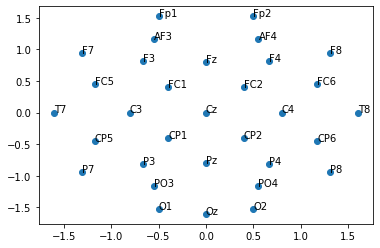

In [4]:
electrodes.plot_2d_projection()

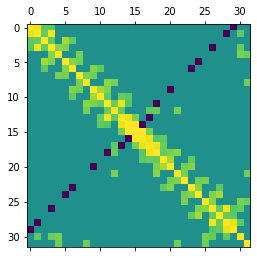

In [7]:
plt.matshow(electrodes.adjacency_matrix)

Fp1 AF3 0.931282740984398
Fp1 F7 0.5016863454282857
Fp1 F3 0.480558158635737
AF3 F7 0.5374678182742632
AF3 F3 0.9457048921821432
AF3 Fz 0.5127175855306214
F7 F3 0.515636997513613
F7 FC5 0.7321005552665446
F7 T7 0.5106496236676452
F3 FC1 0.6431633371779202
F3 FC5 0.605801183468327
F3 Fz 0.5343688044454231
FC1 C3 0.5875602625216685
FC1 Fz 0.5875602625216685
FC1 Cz 0.5601931307358857
FC5 T7 0.6293376854930205
FC5 C3 0.5714990249045929
T7 CP5 0.6293376854930205
T7 P7 0.5106496236676452
C3 CP1 0.5875602625216685
C3 CP5 0.5714990249045929
CP1 P3 0.6431633371779202
CP1 Pz 0.5875602625216685
CP1 Cz 0.5601931307358857
CP5 P7 0.7321005552665446
CP5 P3 0.605801183468327
P7 P3 0.515636997513613
P7 PO3 0.5374678182742632
P7 O1 0.5016863454282857
P3 Pz 0.5343688044454231
P3 PO3 0.9457048921821432
P3 O1 0.480558158635737
Pz PO3 0.5127175855306214
Pz PO4 0.5127175855306214
Pz P4 0.5343688044454231
Pz CP2 0.5875602625216685
PO3 O1 0.931282740984398
PO3 Oz 0.5892007317798547
O1 Oz 1.0
Oz O2 1.0
Oz PO4 0

In [28]:

def generate_in_between_positions(electrodes, num_points = 1):
    """
    Returns new positions in-between current electrodes with a link between them
    :param positions_3d: List of 3D electrode positional information [x,y,z]
    :param adjacency_matrix: Graph adjacency matrix. Will determine where to include the new points
    :param num_points: Number of points to include for each value in the adjacency matrix > 0
    :return: List of positions [x,y,z]
    """
    # Assumes symmetric adj.matrix
    new_points = []
    for i in range(32):
        for j in range(i,32):
            a = electrodes.adjacency_matrix[i,j]
            if i != j and a != 0 and a != -1:
                print(electrodes.channel_names[i],electrodes.channel_names[j],a)
                print(electrodes.positions_3d[i], electrodes.positions_3d[j])
                # ((x_i-x_j/n+1)*m)+x_j = x_ijm
                for n in range(1,num_points+1):
                    new_point = (electrodes.positions_3d[i] + electrodes.positions_3d[j]) / (num_points + 1) 
                    # new_point = electrodes.positions_3d[i] - new_point
                    print(new_point)
                    new_points.append(new_point)
                    

generate_in_between_positions(electrodes,2)
    
    
    

Fp1 AF3 0.931282740984398
[-27  83  -3] [-36  76  24]
[-21.  53.   7.]
[-21.  53.   7.]
Fp1 F7 0.5016863454282857
[-27  83  -3] [-71  51  -3]
[-32.66666667  44.66666667  -2.        ]
[-32.66666667  44.66666667  -2.        ]
Fp1 F3 0.480558158635737
[-27  83  -3] [-48  59  44]
[-25.          47.33333333  13.66666667]
[-25.          47.33333333  13.66666667]
AF3 F7 0.5374678182742632
[-36  76  24] [-71  51  -3]
[-35.66666667  42.33333333   7.        ]
[-35.66666667  42.33333333   7.        ]
AF3 F3 0.9457048921821432
[-36  76  24] [-48  59  44]
[-28.          45.          22.66666667]
[-28.          45.          22.66666667]
AF3 Fz 0.5127175855306214
[-36  76  24] [ 0 63 61]
[-12.          46.33333333  28.33333333]
[-12.          46.33333333  28.33333333]
F7 F3 0.515636997513613
[-71  51  -3] [-48  59  44]
[-39.66666667  36.66666667  13.66666667]
[-39.66666667  36.66666667  13.66666667]
F7 FC5 0.7321005552665446
[-71  51  -3] [-78  30  27]
[-49.66666667  27.           8.        ]
[-49.66